In [55]:
%matplotlib inline

import sqlite3
import itertools as it
import html

import matplotlib.pyplot as plt
import numpy as np

from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

from lda import LDA

In [56]:
FIT_START = 2011 # Fit only articles only after this date
REPORT_START = 2015 # Report only articles after this date
N_CLUSTERS = 25 # No of topics
TOPIC_THRESHOLD = 0.3 # The minimum probability of a topic for a document to be considered part of the topic. For reporting
DATABASE = "repec.sqlite" # See the README on how to create this file

In [57]:
# Get the data
dbcon = sqlite3.connect(DATABASE)
recs = dbcon.execute("""SELECT id,
                        CASE WHEN abstract ISNULL THEN '' ELSE abstract END,
                        CASE WHEN title ISNULL THEN '' ELSE title END,
                        series
                        FROM article WHERE date>=?""",
                    (FIT_START,)).fetchall()
dbcon.close()
len(recs)

9490

In [58]:
# Create word countes
# We drop punctuation, convert to lower case and stem
# Words in title have "T:" prepended to them. This is
#   my crude attempt to have occurence in title count
#   separately from occurence in abstract.
# Adjust min_df and max_df parameters to CountVectorizer to 
#   get enough features but not too many.

stemmer = EnglishStemmer()
stop = set(stopwords.words("english"))

def s_tokenize(text,pre=""):
    toks = (t.lower() for t in wordpunct_tokenize(text) if t.isalnum())    
    return [pre+stemmer.stem(tok) for tok in toks if tok not in stop]

def tokenize(rec):
    return s_tokenize(rec[1],"T:")+s_tokenize(rec[2])
    
vectorizer = CountVectorizer(min_df=0.0005,max_df=0.05,
                             tokenizer = tokenize, 
                             lowercase = False,
                             ngram_range=(1,2))

X = vectorizer.fit_transform(recs)
vocab = np.array(vectorizer.get_feature_names())
X.shape

(9490, 21523)

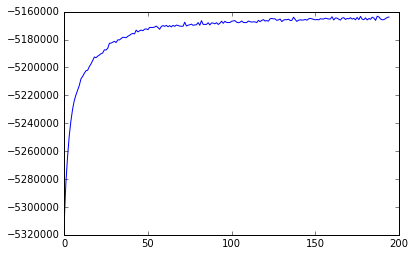

In [59]:
# Fit the model and inspect loglikelihood to diagnose convergence

lda = LDA(N_CLUSTERS)
lda.fit(X)
plt.plot(lda.loglikelihoods_[5:])

In [60]:
# Print the words with the highest probability for each topic to see what the topics are about
# Because of the stemming and the prepending with "T:" this is not fit for human consumption

N_TOP_WORDS = 8
for i, topic_dist in enumerate(lda.topic_word_):
    topic_words = vocab[np.argsort(topic_dist)[:-N_TOP_WORDS:-1]]
    print('Topic {}: {}'.format(i, ', '.join(topic_words)))

Topic 0: T:busi, T:output, T:busi T:cycl, T:sector, T:fluctuat, T:adjust, T:macroeconom
Topic 1: T:tax, T:household, T:wealth, T:insur, T:save, T:life, T:inequ
Topic 2: T:group, T:subject, T:experiment, T:effort, T:influenc, T:particip, T:theoret
Topic 3: T:contract, T:signal, T:ex, T:princip, inform, T:commit, T:ant
Topic 4: T:belief, T:learn, T:ration, T:common, T:prior, T:al, T:et
Topic 5: T:industri, T:univers, T:press, T:univers T:press, T:oxford T:univers, T:oxford, T:export
Topic 6: T:innov, T:human, T:long T:run, T:d, T:human T:capit, T:resourc, growth
Topic 7: T:1, T:year, T:percent, T:0, T:2, T:point, T:declin
Topic 8: T:school, T:program, T:student, T:health, T:educ, T:women, T:children
Topic 9: T:avers, T:uncertainti, T:risk T:avers, T:ambigu, T:discount, T:maker, T:loss
Topic 10: T:hous, T:constraint, T:bubbl, T:hous T:price, T:fundament, T:asset T:price, asset
Topic 11: T:coalit, T:implement, T:core, T:satisfi, T:class, T:solut, T:pareto
Topic 12: T:network, T:option, T:b

In [61]:
# Make one cluster of articles from each topic. 

clusts = []
for i in range(len(recs)):
    c = set()
    for j in range(N_CLUSTERS):
        if lda.doc_topic_[i,j]>TOPIC_THRESHOLD:
            c.add(j)
    c.add(lda.doc_topic_[i].argmax())
    clusts.extend((recs[i][0],str(j)) for j in c)

In [62]:
# Update the database with the cluster labels for articles

dbcon = sqlite3.connect(DATABASE)
dbcon.execute("DROP TABLE IF EXISTS label")
dbcon.execute("CREATE TABLE label (id TEXT, label TEXT)")
dbcon.execute("CREATE INDEX idix ON label(label)")
dbcon.execute("CREATE INDEX labelix ON label(label)")
dbcon.executemany("INSERT INTO label VALUES (?,?)",clusts)
dbcon.commit()
dbcon.close()

In [63]:
# Generate cluster-wise HTML files linking to the articles

dbcon = sqlite3.connect(DATABASE)
distinct_labs = [str(j) for j in range(N_CLUSTERS)]
with open("index.html","w") as f:
    print('<html><head><meta charset="UTF-8"></head><body>',file=f)
    print("<ul>",file=f)
    for lab in distinct_labs:
        print('<li><a href="cluster{}.html">Cluster {}</a></li>'.format(lab,lab),file=f)
    print("</ul>",file=f)
    print("</body></html>",file=f)
for lab in distinct_labs:
    cur = dbcon.execute("""SELECT title,authors,name,date,url FROM article,label,series 
                            WHERE article.id=label.id AND series=seriesid AND label.label=? AND date>=?
                            ORDER BY series.rank,series,date DESC""",(lab,REPORT_START))
    with open("cluster{}.html".format(lab),"w") as f:
        print('<html><head><meta charset="UTF-8"></head><body><ul>',file=f)
        for t,a,n,d,u in cur:
            if t is None:
                continue
            deco_t = None
            if u is not None:
                deco_t = '<a href="{}">{}</a>'.format(html.escape(u),html.escape(t))
            else:
                deco_t = html.escape(t)
            print("<li>{} ({}). {}, <i>{}</i>.</li>".format(html.escape(a),
                                                            html.escape(d),
                                                            deco_t,
                                                            html.escape(n)),
                    file = f)
            
dbcon.close()